# Data Science Challenge - FDIC Data

## 1. Import Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from math import sqrt
# hide warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 2. Data Collection

In [2]:
# Load the data, specify header and index
fdic = pd.read_excel('./loan-performance_aggregate.xls', header=6) 
fdic.head()

,Unnamed: 0,Unnamed: 1,1984Q1,1984Q2,1984Q3,1984Q4,1985Q1,1985Q2,1985Q3,1985Q4,...,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1
0,NaN,Total Real Estate Loans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,30-89 days past due,8162.42,7571.43,7930.49,10459.6,9235.11,8607.09,9262.14,10352,...,34246.1,31517,29425.2,32604,34012.6,31577,28503.3,29707.2,29658.1,29443.9
2,NaN,90 days or more past due,3835.01,3502.91,3438.69,3389.17,3540.05,3281.44,3502.3,3231.31,...,40477.1,36824.3,33724.1,33395.3,36393.4,33618.5,29595,27392,26074.8,24652.2
3,NaN,In nonaccrual status,4991.05,5395.52,5329.21,5169.37,5398.83,6736.63,7542.63,8081.72,...,49441.3,47579.9,45045.6,43838.9,43078.2,42888.3,41255.1,39567.6,38486.7,37494.7
4,NaN,Total outstanding,416437,430872,442921,455607,464783,478992,500482,520460,...,4.60325e+06,4.62687e+06,4.69173e+06,4.7305e+06,4.77366e+06,4.79517e+06,4.83196e+06,4.86319e+06,4.88768e+06,4.90237e+06


## 3. Data Cleaning

In [3]:
# drop 'Unnamed' column
fdic.drop('Unnamed: 0',axis=1,inplace=True)
fdic.head()

,Unnamed: 1,1984Q1,1984Q2,1984Q3,1984Q4,1985Q1,1985Q2,1985Q3,1985Q4,1986Q1,...,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1
0,Total Real Estate Loans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30-89 days past due,8162.42,7571.43,7930.49,10459.6,9235.11,8607.09,9262.14,10352,13861.1,...,34246.1,31517,29425.2,32604,34012.6,31577,28503.3,29707.2,29658.1,29443.9
2,90 days or more past due,3835.01,3502.91,3438.69,3389.17,3540.05,3281.44,3502.3,3231.31,3769.6,...,40477.1,36824.3,33724.1,33395.3,36393.4,33618.5,29595,27392,26074.8,24652.2
3,In nonaccrual status,4991.05,5395.52,5329.21,5169.37,5398.83,6736.63,7542.63,8081.72,8983.84,...,49441.3,47579.9,45045.6,43838.9,43078.2,42888.3,41255.1,39567.6,38486.7,37494.7
4,Total outstanding,416437,430872,442921,455607,464783,478992,500482,520460,536899,...,4.60325e+06,4.62687e+06,4.69173e+06,4.7305e+06,4.77366e+06,4.79517e+06,4.83196e+06,4.86319e+06,4.88768e+06,4.90237e+06


In [4]:
# look for the specific line item 'Total Loans & Leases"
fdic.loc[fdic['Unnamed: 1']== 'Total Loans & Leases'].index[0]

452

In [5]:
# drop all rows prior to 'Total Loans & Leases"
fdic.drop(fdic.index[:fdic.loc[fdic['Unnamed: 1']== 'Total Loans & Leases'].index[0]],inplace=True)
fdic.head()

,Unnamed: 1,1984Q1,1984Q2,1984Q3,1984Q4,1985Q1,1985Q2,1985Q3,1985Q4,1986Q1,...,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1
452,Total Loans & Leases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,30-89 days past due,25815.1,23477.4,24136.3,29877.2,28812.9,26106.5,27672.1,31208.3,37122.9,...,65681.8,61369.6,58410.4,64082.9,67582.7,63131.8,59287.5,63198.3,65401.8,64284.6
454,90 days or more past due,10896.4,9562.18,9403.55,9250.87,9649.14,9500.75,9982.89,9404.48,10481.3,...,53770.1,49951,46153.8,47122.1,51052,47685.5,42741.9,41618.4,42134.1,40355.1
455,In nonaccrual status,32528.2,35042.1,34227.7,34353.2,36269.5,37018.5,37489.6,34484.7,37264.7,...,78242.6,75006.6,70366.7,67717.6,65369.8,64798.8,62092.6,59639.4,58135.6,60376.2
456,Total outstanding,1.47688e+06,1.53509e+06,1.56083e+06,1.6105e+06,1.62164e+06,1.65851e+06,1.70201e+06,1.74754e+06,1.76214e+06,...,9.30714e+06,9.29916e+06,9.46025e+06,9.559e+06,9.72335e+06,9.75465e+06,9.85899e+06,9.94162e+06,1.01546e+07,1.01497e+07


In [6]:
# rename item column
fdic.columns.values[0] = ""
fdic.head()

,,1984Q1,1984Q2,1984Q3,1984Q4,1985Q1,1985Q2,1985Q3,1985Q4,1986Q1,...,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1
452,Total Loans & Leases,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,30-89 days past due,25815.1,23477.4,24136.3,29877.2,28812.9,26106.5,27672.1,31208.3,37122.9,...,65681.8,61369.6,58410.4,64082.9,67582.7,63131.8,59287.5,63198.3,65401.8,64284.6
454,90 days or more past due,10896.4,9562.18,9403.55,9250.87,9649.14,9500.75,9982.89,9404.48,10481.3,...,53770.1,49951,46153.8,47122.1,51052,47685.5,42741.9,41618.4,42134.1,40355.1
455,In nonaccrual status,32528.2,35042.1,34227.7,34353.2,36269.5,37018.5,37489.6,34484.7,37264.7,...,78242.6,75006.6,70366.7,67717.6,65369.8,64798.8,62092.6,59639.4,58135.6,60376.2
456,Total outstanding,1.47688e+06,1.53509e+06,1.56083e+06,1.6105e+06,1.62164e+06,1.65851e+06,1.70201e+06,1.74754e+06,1.76214e+06,...,9.30714e+06,9.29916e+06,9.46025e+06,9.559e+06,9.72335e+06,9.75465e+06,9.85899e+06,9.94162e+06,1.01546e+07,1.01497e+07


In [7]:
#drop prior unneeded rows
fdic.drop([452,453,455],axis=0,inplace=True)
fdic.head()

,,1984Q1,1984Q2,1984Q3,1984Q4,1985Q1,1985Q2,1985Q3,1985Q4,1986Q1,...,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1
454,90 days or more past due,10896.4,9562.18,9403.55,9250.87,9649.14,9500.75,9982.89,9404.48,10481.3,...,53770.1,49951,46153.8,47122.1,51052,47685.5,42741.9,41618.4,42134.1,40355.1
456,Total outstanding,1.47688e+06,1.53509e+06,1.56083e+06,1.6105e+06,1.62164e+06,1.65851e+06,1.70201e+06,1.74754e+06,1.76214e+06,...,9.30714e+06,9.29916e+06,9.46025e+06,9.559e+06,9.72335e+06,9.75465e+06,9.85899e+06,9.94162e+06,1.01546e+07,1.01497e+07
457,30-89 day past due rate,0.0174795,0.0152938,0.0154637,0.0185515,0.0177677,0.015741,0.0162585,0.0178584,0.0210669,...,0.00705715,0.00659948,0.0061743,0.00670394,0.00695056,0.00647197,0.00601355,0.00635694,0.00644063,0.00633362
458,Noncurrent rate,0.0294029,0.0290564,0.0279539,0.0270748,0.0283162,0.0280489,0.027892,0.0251148,0.0270954,...,0.014184,0.0134375,0.0123169,0.0120138,0.0119734,0.0115313,0.0106334,0.0101852,0.00987435,0.00992453
459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# drop all other unneeded rows
fdic = fdic.head(2)
fdic

,,1984Q1,1984Q2,1984Q3,1984Q4,1985Q1,1985Q2,1985Q3,1985Q4,1986Q1,...,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1
454,90 days or more past due,10896.4,9562.18,9403.55,9250.87,9649.14,9500.75,9982.89,9404.48,10481.3,...,53770.1,49951,46153.8,47122.1,51052,47685.5,42741.9,41618.4,42134.1,40355.1
456,Total outstanding,1.47688e+06,1.53509e+06,1.56083e+06,1.6105e+06,1.62164e+06,1.65851e+06,1.70201e+06,1.74754e+06,1.76214e+06,...,9.30714e+06,9.29916e+06,9.46025e+06,9.559e+06,9.72335e+06,9.75465e+06,9.85899e+06,9.94162e+06,1.01546e+07,1.01497e+07


In [9]:
# Transpose the df
fdic = fdic.T
fdic.head()

,454,456
,90 days or more past due,Total outstanding
1984Q1,10896.4,1.47688e+06
1984Q2,9562.18,1.53509e+06
1984Q3,9403.55,1.56083e+06
1984Q4,9250.87,1.6105e+06


In [10]:
new_header = fdic.iloc[0] # assign the first row as the header
fdic = fdic[1:] # keep the data except for the header row
fdic.columns = new_header # set the new header
fdic.head()

,90 days or more past due,Total outstanding
1984Q1,10896.4,1.47688e+06
1984Q2,9562.18,1.53509e+06
1984Q3,9403.55,1.56083e+06
1984Q4,9250.87,1.6105e+06
1985Q1,9649.14,1.62164e+06


In [11]:
# suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)
fdic.head()

,90 days or more past due,Total outstanding
1984Q1,10896.438,1476883.216
1984Q2,9562.185,1535094.275
1984Q3,9403.549,1560829.166
1984Q4,9250.874,1610503.309
1985Q1,9649.138,1621642.066


In [12]:
# show the most recent quarters
fdic.tail()

,90 days or more past due,Total outstanding
2018Q1,47685.493,9754652.980
2018Q2,42741.863,9858992.290
2018Q3,41618.367,9941624.198
2018Q4,42134.055,10154561.523
2019Q1,40355.147,10149734.231


In [13]:
# Add commas to separate thousands
pd.options.display.float_format = '{:,}'.format
fdic.head()

,90 days or more past due,Total outstanding
1984Q1,"10,896.438","1,476,883.216"
1984Q2,"9,562.185","1,535,094.275"
1984Q3,"9,403.549","1,560,829.166"
1984Q4,"9,250.874","1,610,503.309"
1985Q1,"9,649.138","1,621,642.066"


In [14]:
# rename columns for an easy and intuitive reading
fdic.columns = ['past_dues', 'total_loans']
fdic.head()

,past_dues,total_loans
1984Q1,"10,896.438","1,476,883.216"
1984Q2,"9,562.185","1,535,094.275"
1984Q3,"9,403.549","1,560,829.166"
1984Q4,"9,250.874","1,610,503.309"
1985Q1,"9,649.138","1,621,642.066"


In [15]:
# reorder columns to show feature column first and target column second
fdic = fdic[['total_loans', 'past_dues']]
fdic.head(10)

,total_loans,past_dues
1984Q1,"1,476,883.216","10,896.438"
1984Q2,"1,535,094.275","9,562.185"
1984Q3,"1,560,829.166","9,403.549"
1984Q4,"1,610,503.309","9,250.874"
1985Q1,"1,621,642.066","9,649.138"
1985Q2,"1,658,508.801","9,500.751"
1985Q3,"1,702,007.178","9,982.889"
1985Q4,"1,747,543.106","9,404.482"
1986Q1,"1,762,142.863","10,481.283"
1986Q2,"1,795,150.359","10,608.153"


In [16]:
#shift columns up by 2 quarters (six months)
fdic['past_dues'] = fdic['past_dues'].shift(-2)
fdic.head()

,total_loans,past_dues
1984Q1,"1,476,883.216","9,403.549"
1984Q2,"1,535,094.275","9,250.874"
1984Q3,"1,560,829.166","9,649.138"
1984Q4,"1,610,503.309","9,500.751"
1985Q1,"1,621,642.066","9,982.889"


In [17]:
#check the NaN created at the tail due to the shift
fdic.tail()

,total_loans,past_dues
2018Q1,"9,754,652.98","41,618.367"
2018Q2,"9,858,992.29","42,134.055"
2018Q3,"9,941,624.198","40,355.147"
2018Q4,"10,154,561.523",NaN
2019Q1,"10,149,734.231",NaN


In [18]:
# preserve those two quarters for later testing of the model
last_quarters = fdic.tail(2)

In [19]:
# drop last quarters with no corresponding past_dues
fdic.dropna(inplace=True)
fdic.shape

(139, 2)

In [20]:
# rename the columns to reflect forward looking 
fdic.columns = ['current_loans', 'future_past_dues']
fdic.head()

,current_loans,future_past_dues
1984Q1,"1,476,883.216","9,403.549"
1984Q2,"1,535,094.275","9,250.874"
1984Q3,"1,560,829.166","9,649.138"
1984Q4,"1,610,503.309","9,500.751"
1985Q1,"1,621,642.066","9,982.889"


## 4. Data Analysis

In [21]:
# convert columns to float64 to run correlation
fdic['current_loans']=np.float64(fdic['current_loans'])
fdic['future_past_dues']=np.float64(fdic['future_past_dues'])

# see how the two columns correlate
fdic['current_loans'].corr(fdic['future_past_dues'])

0.6731601864411647

#### as expected `total_loans` and `past_dues` are strongly correlated

In [22]:
# R-squared (=correlation**2)
fdic['current_loans'].corr(fdic['future_past_dues'])**2

0.45314463660950366

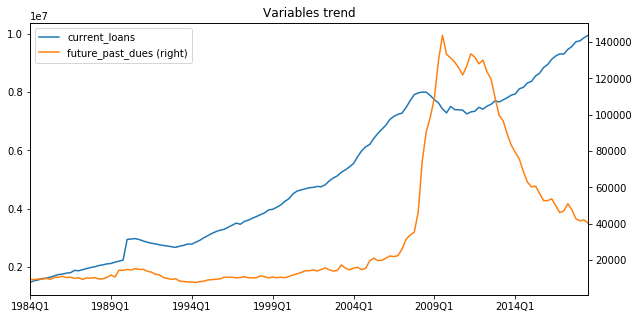

In [23]:
# create a plot to visualize the relationship between the dependant and independant variables
plt.figure(figsize=(10,5))
plt.title('Variables trend')
fdic.current_loans.plot(legend=True)
fdic.future_past_dues.plot(secondary_y=True,legend=True);

**The graph shows the spike in past dues with the beginning of the 2008 financial crisis. 
During that same period, the size of the outstanding loans has also shrunk reflecting the credit crunch.**

## 5. Model selection

In [24]:
#creation of the predictor (X) and the target variable (y)
X = fdic[['current_loans']]
y = fdic['future_past_dues']

In [25]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [26]:
# import the regression models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

In [27]:
# instantiat the regression models
lr = LinearRegression()
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor()
bag = BaggingRegressor()
forest = RandomForestRegressor()
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

## 6. Model Evaluation

### 6.1. R-squared Evaluation

In [28]:
# create a function to produce R2 scores for the different models
def r2_evaluate(model):
    model.fit(X_train, y_train)
    model_y_train_pred = model.predict(X_train)
    model_y_test_pred = model.predict(X_test)
    r2_model_train = r2_score(y_train, model_y_train_pred)
    r2_model_test = r2_score(y_test, model_y_test_pred)
    return r2_model_train, r2_model_test

In [29]:
# create a df to easily compare models 
models_r2 = pd.DataFrame({'LR':r2_evaluate(lr), 'KNN':r2_evaluate(knn), 'Decision Trees': r2_evaluate(tree),
              'Bagging': r2_evaluate(bag), 'Random Forest': r2_evaluate(forest),
              'Adaboost': r2_evaluate(ada)}, index=['train','test'])
models_r2.round(3)

,LR,KNN,Decision Trees,Bagging,Random Forest,Adaboost
train,0.455,0.809,1.0,0.946,0.909,0.996
test,0.447,0.961,0.983,0.987,0.957,0.984


**Decision Trees and Adaboost model resulted in the best outcome in terms of R2, without creating in an overfit, as can be seen in the difference between the train and test results and represent a big improvement from a simple linear regression**

### 6.2. Root Mean Square Error Evaluation

In [30]:
def rmse_evaluate(model):
    model.fit(X_train, y_train)
    model_y_train_pred = model.predict(X_train)
    model_y_test_pred = model.predict(X_test)
    rmse_model_train = sqrt(mean_squared_error(y_train, model_y_train_pred))
    rmse_model_test = sqrt(mean_squared_error(y_test, model_y_test_pred))
    return rmse_model_train, rmse_model_test

In [31]:
rmse_models = pd.DataFrame({'LR':rmse_evaluate(lr), 'KNN':rmse_evaluate(knn), 'Decision Trees': rmse_evaluate(tree),
              'Bagging': rmse_evaluate(bag), 'Random Forest': rmse_evaluate(forest),
              'Adaboost': rmse_evaluate(ada)}, index=['train','test'])
rmse_models.astype(int) # remove decimals

,LR,KNN,Decision Trees,Bagging,Random Forest,Adaboost
train,28792,17033,0,10157,9413,3694
test,30120,7977,5217,6718,5252,5750


**RMSE evaluation confirms the superiority of the Decision Tree and Adaboost models in reducing errors over the other models and a clear improvement from the linear regression**

In [32]:
# df showing preds vs actuals using the best model
predictions = tree.predict(X_test)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0:'predicted_past_dues'}, inplace=True)
predictions['actual_past_dues'] = y_test.values
predictions['total_loans'] = X_test.values
predictions.index = X_test.index
predictions = predictions[['total_loans', 'actual_past_dues', 'predicted_past_dues']]
predictions.tail()

,total_loans,actual_past_dues,predicted_past_dues
1986Q3,"1,811,747.008","10,598.787","10,388.673"
1998Q1,"3,736,303.233","10,357.068","11,333.489"
2010Q1,"7,505,475.436","131,318.446","123,665.56"
2000Q2,"4,506,147.434","11,781.846","13,119.718"
2010Q2,"7,398,653.369","129,038.284","125,934.097"


In [33]:
# sort by index and show most recent predictions of validation set
predictions.sort_index(inplace=True)
predictions.tail()

,total_loans,actual_past_dues,predicted_past_dues
2015Q3,"8,644,194.506","56,682.34","60,737.651"
2016Q3,"9,234,872.4","49,951.038","46,153.783"
2017Q1,"9,299,157.833","47,122.093","46,153.783"
2017Q3,"9,558,996.31","47,685.493","51,052.026"
2017Q4,"9,723,345.525","42,741.863","41,618.367"


In [34]:
# recall of last quarter with past_dues not yet known
last_quarters

,total_loans,past_dues
2018Q4,"10,154,561.523",NaN
2019Q1,"10,149,734.231",NaN


In [35]:
# rename the columns to reflect unknown data
last_quarters.columns = ['total_loans', 'predicted_past_dues']
last_quarters

,total_loans,predicted_past_dues
2018Q4,"10,154,561.523",NaN
2019Q1,"10,149,734.231",NaN


In [36]:
# use best model to predict unseen data
last_quarters['predicted_past_dues'] = tree.predict(last_quarters[['total_loans']])
last_quarters

,total_loans,predicted_past_dues
2018Q4,"10,154,561.523","40,355.147"
2019Q1,"10,149,734.231","40,355.147"


The predicted amounts are the same due to the step-wise approach of the decision tree model and the loan amounts being close.